In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'diamond-price-prediciton-2024:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F77458%2F8457230%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240525%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240525T084516Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D846e245c80b667c1276a8f7a4f04d256dab21a9afa2381169c001698e9d09ef7a3d44fd91a030ee97afc934566ef6eff498e4689ffa57f64d61c14882ca11ccbe82ff319d29b8ccc3fcb059b4a4522f8ed2f5e88b481a52e2e6e1619bc3373a2f65cc4c277ef7dda740bea2695d8ee1b242540b079d9a4284ac94a22013e5f980d381116487b89c6cdc4b588446e5bd47a8972fb21a30388a046cf3c75e220bb7949466ff5137fae8218e6d278e85b2c0442023daaca1581a17060f159080ba82a930fa76740ba1be5419e6390aed3bfc9e3e1d6cdaad7f550e491d4f3e34269074ca42f2b6a2f5785bb53a8919a7b5cd4b1d03db25d8f1848be5f1e9250ae21'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 885571 bytes downloaded
Downloaded and uncompressed: diamond-price-prediciton-2024
Data source import complete.


# Importing Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint, uniform
from sklearn.metrics import mean_squared_error

# Reading Data

In [3]:
train_df=pd.read_csv('/kaggle/input/diamond-price-prediciton-2024/train.csv')
test_df=pd.read_csv('/kaggle/input/diamond-price-prediciton-2024/test.csv')

In [4]:
ID = test_df['Id']
train_df.drop(['Id'], axis=1, inplace = True)
test_df.drop(['Id'], axis=1, inplace = True)

In [5]:
train_df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,1.06,Ideal,I,SI2,61.8,57.0,4270,6.57,6.60,4.07
1,1.51,Premium,G,VVS2,60.9,58.0,15164,7.38,7.42,4.51
2,0.32,Ideal,F,VS2,61.3,56.0,828,4.43,4.41,2.71
3,0.53,Ideal,G,VS2,61.2,56.0,1577,5.19,5.22,3.19
4,0.70,Premium,H,VVS2,61.0,57.0,2596,5.76,5.72,3.50


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43152 entries, 0 to 43151
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    43152 non-null  float64
 1   cut      43152 non-null  object 
 2   color    43152 non-null  object 
 3   clarity  43152 non-null  object 
 4   depth    43152 non-null  float64
 5   table    43152 non-null  float64
 6   price    43152 non-null  int64  
 7   x        43152 non-null  float64
 8   y        43152 non-null  float64
 9   z        43152 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 3.3+ MB


In [7]:
train_df.describe()

,carat,depth,table,price,x,y,z
count,43152.000000,43152.000000,43152.000000,43152.000000,43152.000000,43152.000000,43152.000000
mean,0.797855,61.747177,57.458347,3929.491912,5.731568,5.735018,3.538568
std,0.473594,1.435454,2.233904,3985.527795,1.121279,1.148809,0.708238
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,947.750000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5312.000000,6.540000,6.540000,4.040000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


# Checking Missing Values

In [8]:
train_df.isna().sum()

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64

# Data Visualization

array([[<Axes: title={'center': 'carat'}>,
        <Axes: title={'center': 'depth'}>,
        <Axes: title={'center': 'table'}>],
       [<Axes: title={'center': 'price'}>, <Axes: title={'center': 'x'}>,
        <Axes: title={'center': 'y'}>],
       [<Axes: title={'center': 'z'}>, <Axes: >, <Axes: >]], dtype=object)

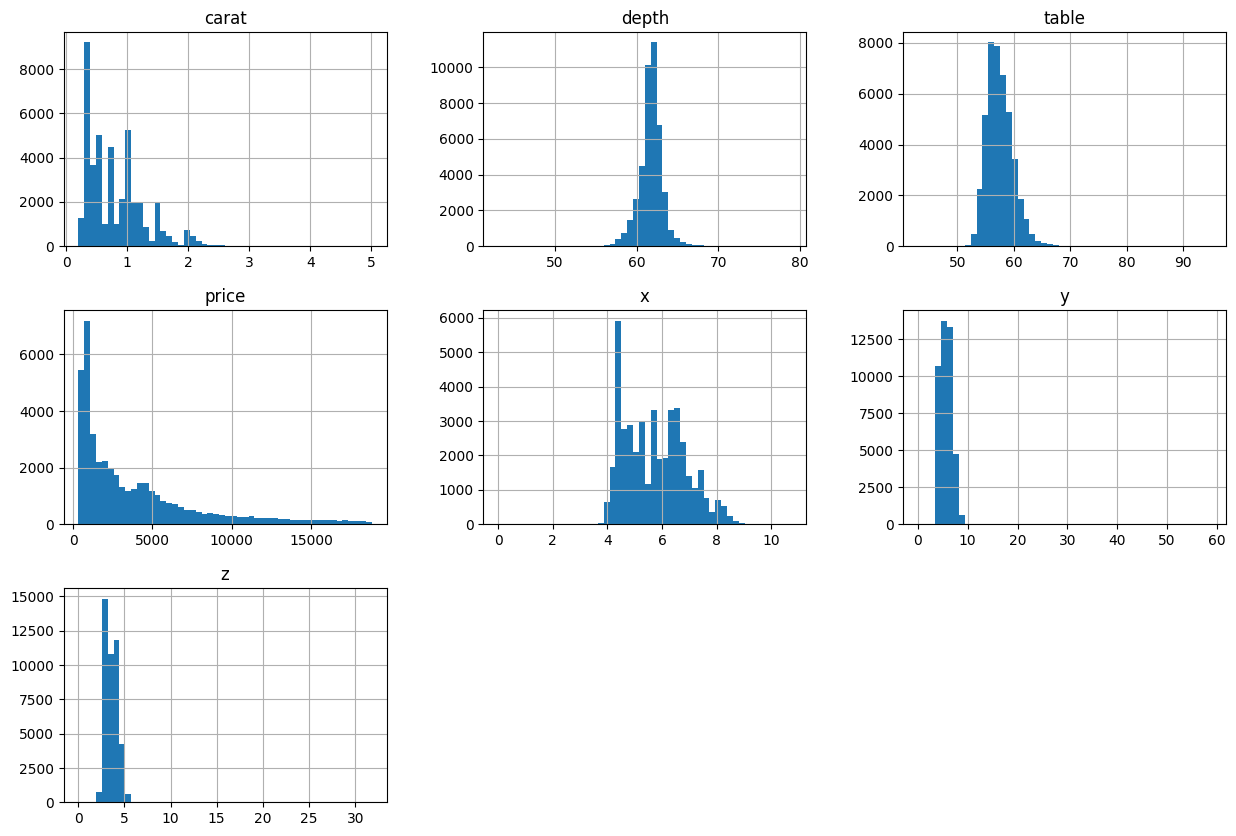

In [9]:
train_df.hist(figsize = (15,10),bins = 50)

In [10]:
fix_skew = ['carat', 'table', 'x', 'y', 'z']
train_df[fix_skew] = np.log(train_df[fix_skew] + 1)
test_df[fix_skew] = np.log(train_df[fix_skew] + 1)

array([[<Axes: title={'center': 'carat'}>,
        <Axes: title={'center': 'depth'}>,
        <Axes: title={'center': 'table'}>],
       [<Axes: title={'center': 'price'}>, <Axes: title={'center': 'x'}>,
        <Axes: title={'center': 'y'}>],
       [<Axes: title={'center': 'z'}>, <Axes: >, <Axes: >]], dtype=object)

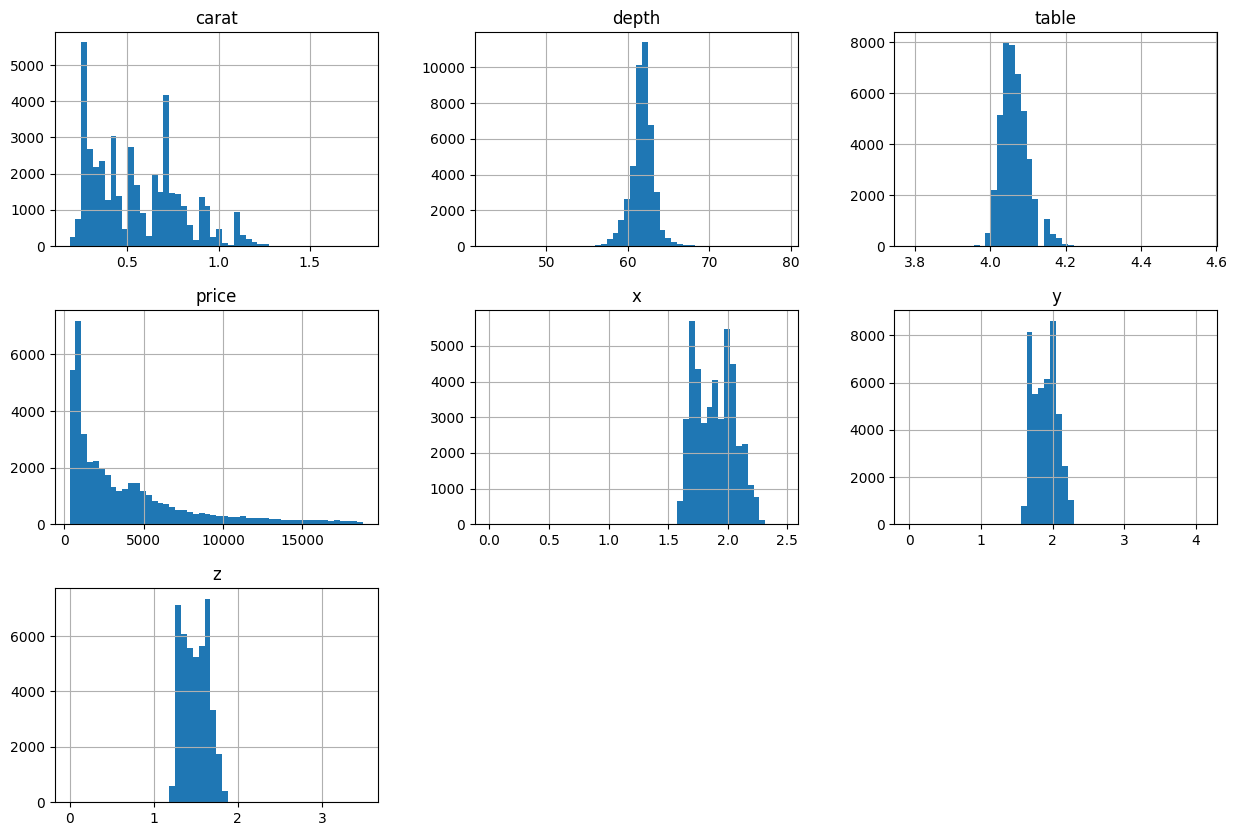

In [11]:
train_df.hist(figsize = (15,10),bins = 50)

cut
Ideal        17203
Premium      11113
Very Good     9658
Good          3881
Fair          1297
Name: count, dtype: int64


<Axes: >

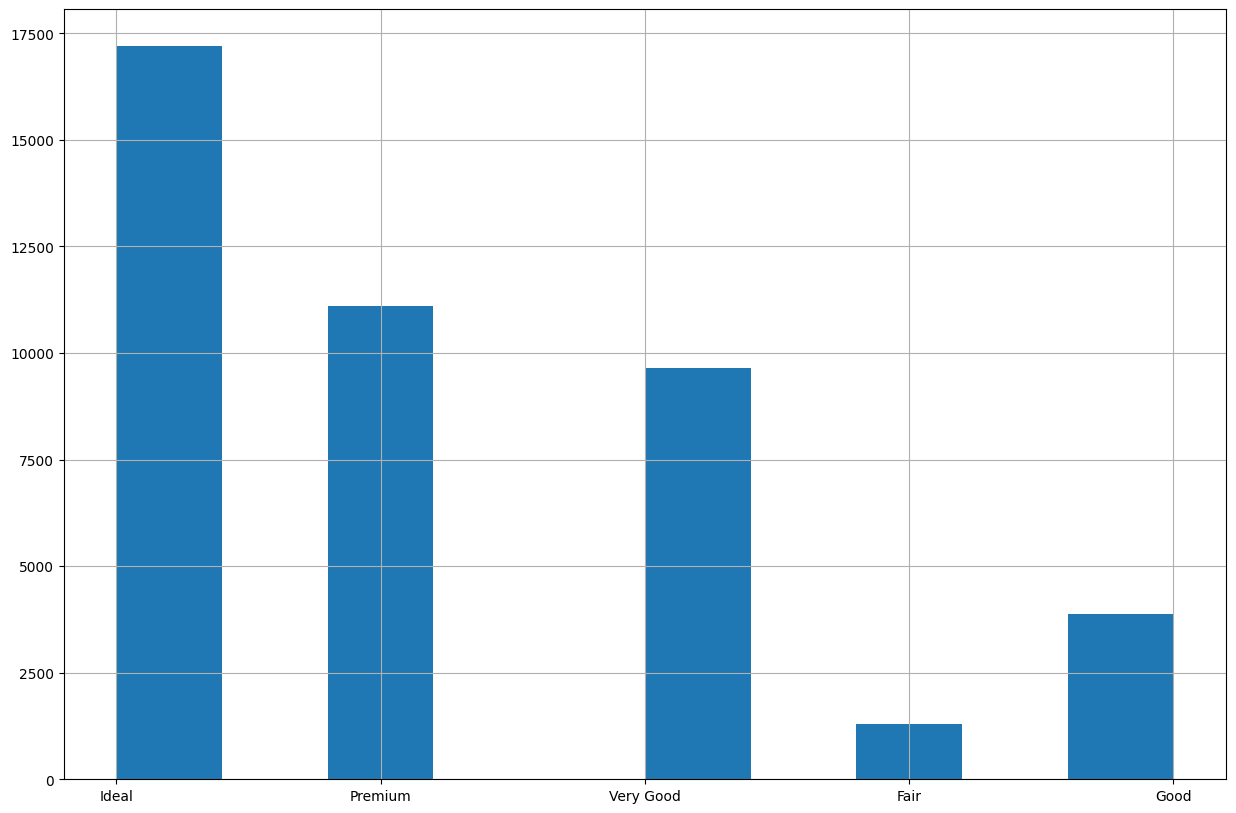

In [12]:
plt.figure(figsize=(15, 10))
cut_counts = train_df['cut'].value_counts()
print(cut_counts)
train_df['cut'].hist()

color
D    3164.045932
E    3092.903218
F    3719.834010
G    3976.235430
H    4483.972485
I    5128.529426
J    5273.038865
Name: price, dtype: float64


<BarContainer object of 7 artists>

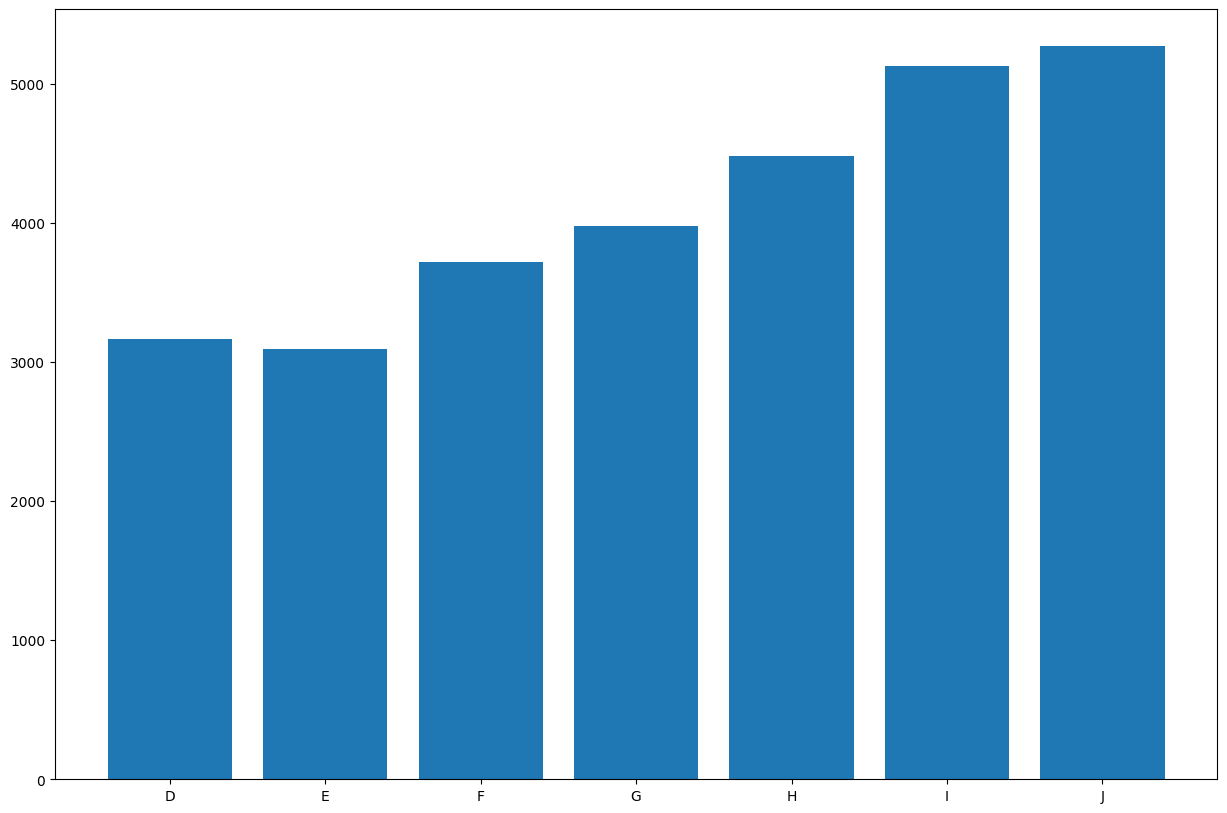

In [13]:
plt.figure(figsize=(15, 10))
mean_by_color = train_df.groupby("color")["price"].mean()
print(mean_by_color)
plt.bar(mean_by_color.index, mean_by_color)

# Fixing Categorical Data Types

In [14]:
cat_cols = ['cut', 'clarity', 'color']

for cat in cat_cols:
    train_df[cat] = train_df[cat].astype('category')
    test_df[cat] = test_df[cat].astype('category')

train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43152 entries, 0 to 43151
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   carat    43152 non-null  float64 
 1   cut      43152 non-null  category
 2   color    43152 non-null  category
 3   clarity  43152 non-null  category
 4   depth    43152 non-null  float64 
 5   table    43152 non-null  float64 
 6   price    43152 non-null  int64   
 7   x        43152 non-null  float64 
 8   y        43152 non-null  float64 
 9   z        43152 non-null  float64 
dtypes: category(3), float64(6), int64(1)
memory usage: 2.4 MB


# Checking For Outliers

In [15]:
train_df['total_depth_per'] = 2*train_df['z'] / (train_df['x'] + train_df['y'])
test_df['total_depth_per'] = 2*test_df['z'] / (test_df['x'] + test_df['y'])

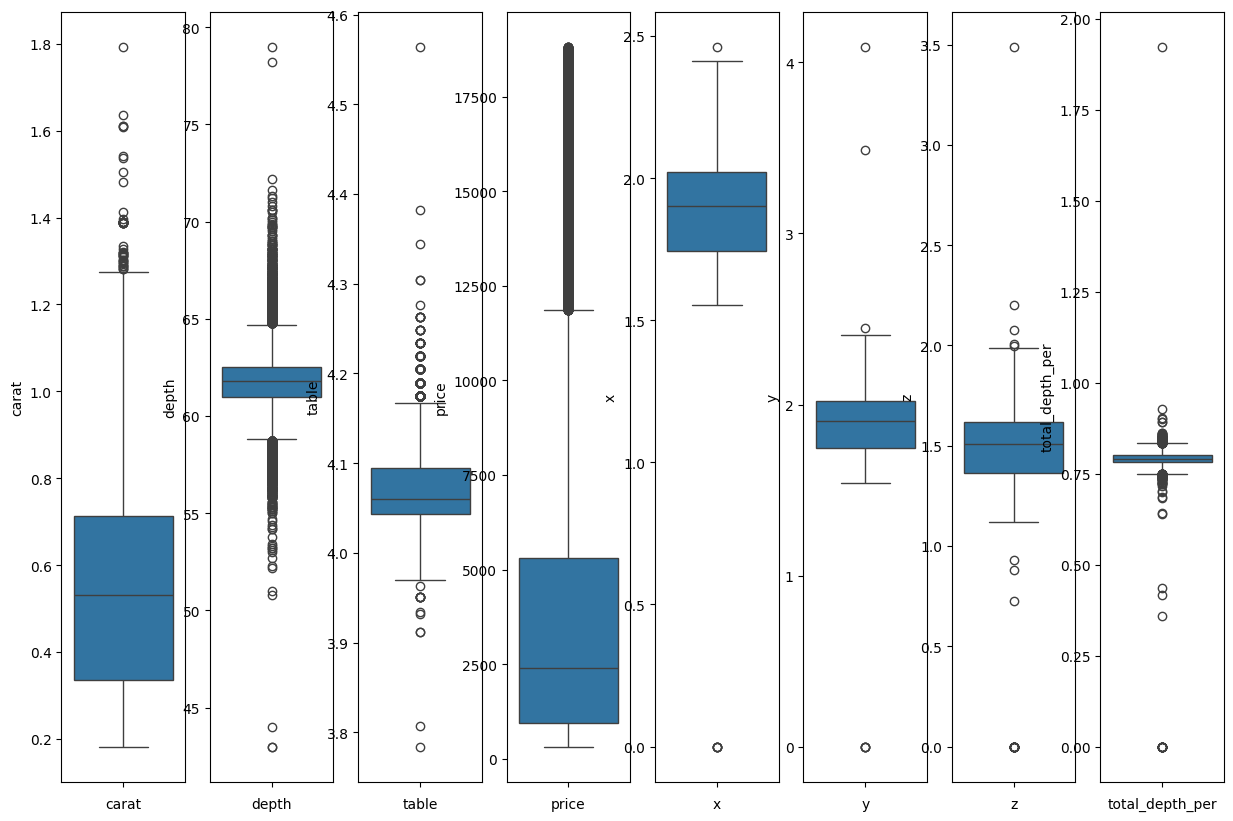

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt


features = [col for col in train_df.columns if col not in cat_cols]
fig, ax = plt.subplots(1, len(features), figsize=(15, 10))
sns.set(rc={"figure.figsize": (6, 4)})

for i, feature in enumerate(features):
    sns.boxplot(data=train_df[feature], ax=ax[i])
    ax[i].set_xlabel(feature)

plt.show()

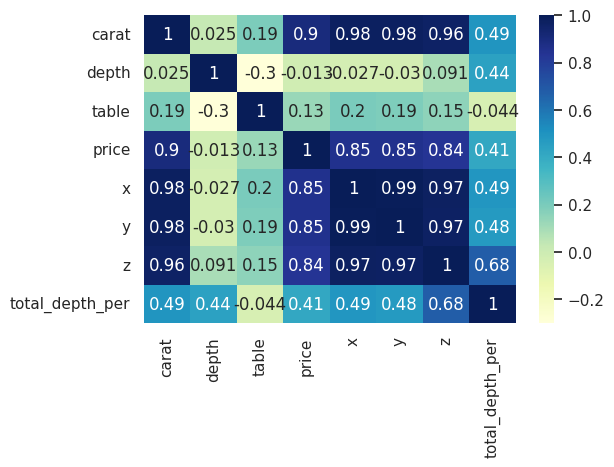

In [17]:
sns.heatmap(train_df[features].corr(), cmap='YlGnBu', annot=True)
plt.show()

In [18]:
encoding_dict = [
    ['Fair', 'Good', 'Very Good', 'Premium', 'Ideal'],
    ['I1', 'SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1', 'IF'],
    ['J', 'I', 'H', 'G', 'F', 'E', 'D']
]
encoder = OrdinalEncoder(categories=encoding_dict)
print(train_df)

train_df[['cut_encoded', 'clarity_encoded', 'color_encoded']] = encoder.fit_transform(train_df[['cut', 'clarity', 'color']])
test_df[['cut_encoded', 'clarity_encoded', 'color_encoded']] = encoder.fit_transform(test_df[['cut', 'clarity', 'color']])

train_df.drop(['cut', 'clarity', 'color'], axis=1, inplace=True)
test_df.drop(['cut', 'clarity', 'color'], axis=1, inplace=True)
train_df.dropna(inplace=True)

train_df.head()

          carat        cut color clarity  depth     table  price         x  \
0      0.722706      Ideal     I     SI2   61.8  4.060443   4270  2.024193   
1      0.920283    Premium     G    VVS2   60.9  4.077537  15164  2.125848   
2      0.277632      Ideal     F     VS2   61.3  4.043051    828  1.691939   
3      0.425268      Ideal     G     VS2   61.2  4.043051   1577  1.822935   
4      0.530628    Premium     H    VVS2   61.0  4.060443   2596  1.911023   
...         ...        ...   ...     ...    ...       ...    ...       ...   
43147  0.418710      Ideal     E     VS2   61.5  4.043051   1760  1.818077   
43148  0.542324  Very Good     D     VS2   62.1  4.094345   3016  1.902108   
43149  0.364643    Premium     I    VVS1   61.5  4.077537    990  1.783391   
43150  0.270027    Premium     E     VS1   60.2  4.077537    734  1.682688   
43151  0.285179      Ideal     G     VS2   61.2  4.025352    743  1.702928   

              y         z  total_depth_per  
0      2.028148  1

,carat,depth,table,price,x,y,z,total_depth_per,cut_encoded,clarity_encoded,color_encoded
0,0.722706,61.8,4.060443,4270,2.024193,2.028148,1.623341,0.801187,4.0,1.0,1.0
1,0.920283,60.9,4.077537,15164,2.125848,2.130610,1.706565,0.801871,3.0,5.0,3.0
2,0.277632,61.3,4.043051,828,1.691939,1.688249,1.311032,0.775715,4.0,3.0,4.0
3,0.425268,61.2,4.043051,1577,1.822935,1.827770,1.432701,0.784890,4.0,3.0,3.0
4,0.530628,61.0,4.060443,2596,1.911023,1.905088,1.504077,0.788278,3.0,5.0,2.0


# Normalizing Numerical Features

In [19]:
to_scale = ['total_depth_per', 'carat', 'table', 'x', 'y', 'z', 'depth']
scaler = StandardScaler()
scaler.fit(train_df[to_scale])
train_df[to_scale] = scaler.transform(train_df[to_scale])
scaler.fit(test_df[to_scale])
test_df[to_scale] = scaler.transform(test_df[to_scale])

train_df.head()

,carat,depth,table,price,x,y,z,total_depth_per,cut_encoded,clarity_encoded,color_encoded
0,0.684010,0.036814,-0.189462,4270,0.794541,0.819740,0.798888,0.453898,4.0,1.0,1.0
1,1.491211,-0.590239,0.263497,15164,1.411355,1.444900,1.342098,0.487011,3.0,5.0,3.0
2,-1.134343,-0.311549,-0.650299,828,-1.221488,-1.254124,-1.239583,-0.778827,4.0,3.0,4.0
3,-0.531176,-0.381221,-0.650299,1577,-0.426639,-0.402850,-0.445438,-0.334808,4.0,3.0,3.0
4,-0.100725,-0.520566,-0.189462,2596,0.107854,0.068900,0.020444,-0.170856,3.0,5.0,2.0


# Fitting Random Forest Regressor

In [20]:
model = RandomForestRegressor()

X_train = train_df.drop(['price'], axis=1)
y_train = train_df['price']

model.fit(X_train, y_train)

RandomForestRegressor()

# Testing Model On Training Set

In [21]:
y_train_pred = model.predict(X_train)
rmse = mean_squared_error(y_train, y_train_pred, squared=False)
print("Mean Squared Error:", rmse)

Mean Squared Error: 201.43700188095806


# Predicting Test Values

In [22]:
test_df = test_df.fillna(1)
y_pred = model.predict(test_df)
y_pred

array([ 8698.81, 13387.64,   593.67, ...,  1070.78,  4326.59,  3462.6 ])

In [23]:
data = {'ID':ID, 'price':y_pred}
sub = pd.DataFrame(data)
sub.to_csv('submission.csv', index=False)